In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from collections import deque
import pygame
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class ActorCritic_CartPole(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(4,128)
        self.layer_1_actor=nn.Linear(128,2)
        self.layer_1_critic=nn.Linear(128,1)

    def forward(self, input):
        input=input.view(-1,4)
        x=F.relu(self.layer_1(input))
        policy=self.layer_1_actor(x)
        critic=self.layer_1_critic(x)
        return policy,critic

In [ ]:
def ActorCriticTrain_CartPole(model,optimizer,episodes=1600,gamma=0.99):
  global total_rewards
  total_rewards=[]
  env=gym.make('CartPole-v1')
  model.train()
  max_length=500
  for episode in range(episodes):
    done=False
    obs,_=env.reset()
    total_reward=0
    length=0
    log_prob_list=[]
    rewards=[]
    values=[]
    while not done:
      state=torch.from_numpy(obs).float().to(device)
      policy,value=model(state)
      policy=torch.squeeze(policy)
      probs = torch.nn.functional.softmax(policy, dim=0)
      action = torch.multinomial(probs, num_samples=1).item()
      log_prob=torch.log(probs[action])
      obs,reward,done,_,_=env.step(action)
      total_reward+=reward
      state=torch.from_numpy(obs).float().to(device)
      log_prob_list.append(log_prob)
      rewards.append(reward)
      values.append(value.squeeze())
      length+=1
      if length==max_length:
        done=True

    total_rewards.append(total_reward)

    ep_len = len(rewards)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    discounted = rewards * torch.pow(gamma, torch.arange(ep_len, dtype=torch.float32).to(device))
    returns = torch.flip(torch.cumsum(torch.flip(discounted, dims=[0]), dim=0), dims=[0])
    returns = returns / torch.pow(gamma, torch.arange(ep_len, dtype=torch.float32)).to(device)

    log_prob_list=torch.stack(log_prob_list).to(device)
    values=torch.stack(values).to(device)
    actor_loss=-torch.sum((returns-values.detach())*log_prob_list)
    critic_loss=F.mse_loss(values,returns)
    loss=actor_loss+critic_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if episode%50==0 and episode>0:
      print(f"Episode = {episode} Average Reward = {sum(total_rewards[-50::])/50 :.2f}")
      if sum(total_rewards[-50::])/50>=470:
        break

  env.close()

In [ ]:
model=ActorCritic_CartPole().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
ActorCriticTrain_CartPole(model,optimizer)

Episode = 50 Average Reward = 27.86
Episode = 100 Average Reward = 35.86
Episode = 150 Average Reward = 47.48
Episode = 200 Average Reward = 53.16
Episode = 250 Average Reward = 87.38
Episode = 300 Average Reward = 124.70
Episode = 350 Average Reward = 150.66
Episode = 400 Average Reward = 248.66
Episode = 450 Average Reward = 322.66
Episode = 500 Average Reward = 465.58
Episode = 550 Average Reward = 474.96


[]

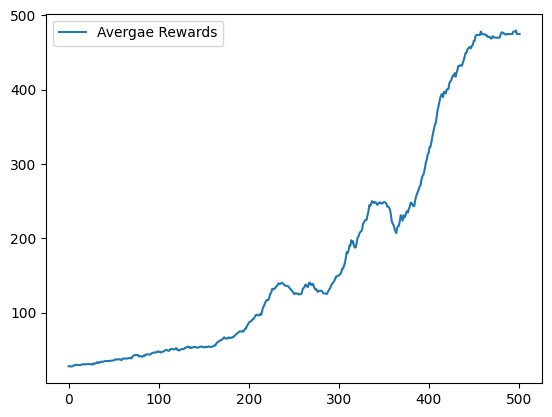

In [ ]:
plt.plot(np.convolve(total_rewards,np.ones(50)*0.02,mode='valid'),label='Avergae Rewards')
plt.legend()
plt.plot()

In [ ]:
def evaluate_cartpole_model(model, episodes=15, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()

    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state)[0]
                action = torch.argmax(q_values, dim=1).item()
            obs, reward, done, truncated, _ = env.step(action)
            if truncated:
              done=True
            total_reward += reward
            if render:
                env.render()
        rewards.append(total_reward)
        print(f"Episode {episode + 1}: Reward = {total_reward}")

    env.close()
    avg_reward = sum(rewards) / episodes
    print(f"Average reward over {episodes} episodes: {avg_reward}")

In [ ]:
evaluate_cartpole_model(model,render=False)

Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 500.0
Episode 7: Reward = 500.0
Episode 8: Reward = 500.0
Episode 9: Reward = 500.0
Episode 10: Reward = 500.0
Episode 11: Reward = 500.0
Episode 12: Reward = 500.0
Episode 13: Reward = 500.0
Episode 14: Reward = 500.0
Episode 15: Reward = 500.0
Average reward over 15 episodes: 500.0
